In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv('Data/adult.data', header=None, skipinitialspace=True)
data.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',\
                'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week',\
                'native-country', 'income']

data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# Missing values are denoted as '?' in the data.
# We can see there are a few columns that are missing data.
# I am going to try two different approaches for dealing with this later on.
data.replace('?', np.nan, inplace=True)
data.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

# What does the data look like and how do we want it to look?

Age -- Continuous, no missing values

Workclass -- Categorical, what sector is their employment in.  A few missing values, but we can probably bucketize this.

fnlweight -- Continuous, this mertic explains how common the line item is for the nation.  I think this should be removed, but will test both.

Education -- Categorical, will remove and use Education-Num.

Education-Num -- Continuous, same info as education.

Marital-Status -- Categorical, no missing values.

Occupation -- Categorical, some missing values.  This is going to be a lot of unique values, I think this will be punted and workclass used.

Relationship -- Categorical, may look to reduce dimenstionality for this one.

Race -- Categorical, pretty concentrated, will probably dum-ify these.

Sex -- Categorical, two options

Capital-gain -- Continuous, mostly 0, we can possibly change this to be a bool if greater than zero.

Capital-loss -- Continuous, mostly 0, we can possibly change this to be a bool if greater than zero.

Hours-per-week -- Continuous

Native-country -- Categorical, missing a few values.  Mostly concentraded as US, will summarize.

Income -- Categorical, target value, what we are trying to predict.

### Workclass

In [4]:
# I suspect there is a good chunk of overlap here.
data['workclass'].value_counts(normalize=True, dropna=False)

Private             0.697030
Self-emp-not-inc    0.078038
Local-gov           0.064279
NaN                 0.056386
State-gov           0.039864
Self-emp-inc        0.034274
Federal-gov         0.029483
Without-pay         0.000430
Never-worked        0.000215
Name: workclass, dtype: float64

In [5]:
# We will need to dummy this, but this will control some of the dimensionality.
### NOTE: We are overwriting the NAN's and setting them to 3 (other) we should make note of this for when we test.
gov_jobs = ['Local-gov', 'State-gov', 'Federal-gov']
self_emp_jobs = ['Self-emp-not-inc', 'Self-emp-inc']

data['workclass-cat'] = 3
data.loc[data['workclass'].isin(self_emp_jobs), 'workclass-cat'] = 2
data.loc[data['workclass'].isin(gov_jobs), 'workclass-cat'] = 1
data.loc[data['workclass'] == 'Private', 'workclass-cat'] = 0

data['workclass-cat'].value_counts(normalize=True)

0    0.697030
1    0.133626
2    0.112312
3    0.057031
Name: workclass-cat, dtype: float64

### Education and Education Num

In [6]:
# Quick look at education, we can boot this.  Education-Num is inclusive enough.
data[['education', 'education-num']].groupby('education').mean()

,education-num
education,
10th,6
11th,7
12th,8
1st-4th,2
5th-6th,3
7th-8th,4
9th,5
Assoc-acdm,12
Assoc-voc,11


### Marital Status

In [7]:
data['marital-status'].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

In [8]:
data['relationship'].value_counts()

Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64

### Race and Native Country

In [70]:
# We can honestly make this into 'White', 'Black', 'Other'
data['race'].value_counts(normalize=True)

data['race-cat'] = 2
data.loc[data['race'] == 'Black', 'race-cat'] = 1
data.loc[data['race'] == 'White', 'race-cat'] = 0

KeyError: 'race'

In [10]:
data['native-country'].value_counts(normalize=True).head(5)

United-States    0.912190
Mexico           0.020108
Philippines      0.006192
Germany          0.004284
Canada           0.003784
Name: native-country, dtype: float64

In [11]:
# Since a vast majority come from the US, and everything else is less than 2%, lets make a new column that is US Bool
data['from-US'] = 0
data.loc[data['native-country'] == 'United-States', 'from-US'] = 1
data['from-US'].astype('object')
data['from-US'].value_counts(normalize=True)

1    0.895857
0    0.104143
Name: from-US, dtype: float64

### Sex

In [12]:
# We should convert sex from string to binary.  Easy enough.
data['sex'] = data['sex'].map({'Male':1,'Female':0}).astype(object)
data['sex'].value_counts(normalize=True)

1    0.669205
0    0.330795
Name: sex, dtype: float64

### Capitol Gain and Loss

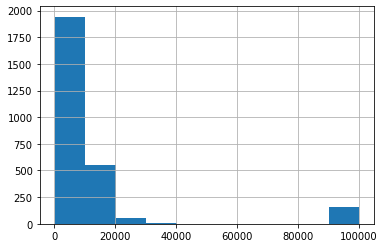

In [13]:
data.loc[data['capital-gain'] > 0, 'capital-gain'].hist()

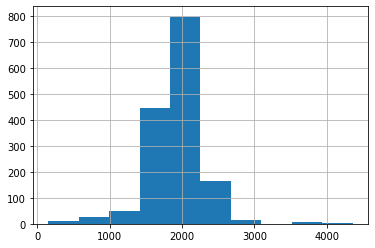

In [14]:
data.loc[data['capital-loss'] > 0, 'capital-loss'].hist()

In [15]:
# I think there might be some insight to be gained here, so am going to scale these a bit.
data['capital-gain-scaled'] = data['capital-gain'] / data['capital-gain'].max()
data['capital-loss-scaled'] = data['capital-loss'] / data['capital-loss'].max()

# A Couple Graphs to Demonstrate Relationships

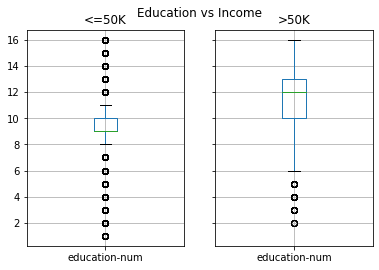

In [16]:
income_by_education = data[['income', 'education-num']].groupby('income')
income_by_education.boxplot()
plt.suptitle('Education vs Income')
plt.show()
# Not surprisingly, we can see that those who make >50k a year have more years of education
# I kinda want to expand this a bit

[Text(0.5, 1.0, 'CDF Income vs Age')]

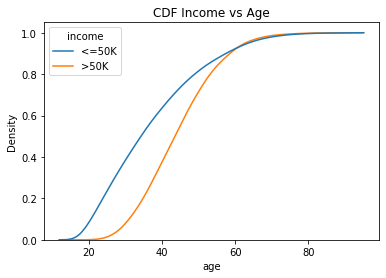

In [17]:
sns.kdeplot(data=data[['age','income']], x='age', hue='income',\
            cumulative=True, common_norm=False, common_grid=True).set(title='CDF Income vs Age')
# There is a big age gap here, which is also intuitive.
# People are not going to make more than 50k in their early years of productivity.

[Text(0.5, 1.0, 'CDF Income vs Hours Worked Per Week')]

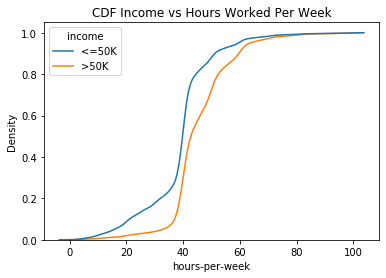

In [18]:
sns.kdeplot(data=data[['hours-per-week','income']], x='hours-per-week', hue='income',\
            cumulative=True, common_norm=False, common_grid=True).set(title='CDF Income vs Hours Worked Per Week')
# This is also intuitive, those who make more than 50k a year end up working more hours on average

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 20 columns):
age                    32561 non-null int64
workclass              30725 non-null object
fnlwgt                 32561 non-null int64
education              32561 non-null object
education-num          32561 non-null int64
marital-status         32561 non-null object
occupation             30718 non-null object
relationship           32561 non-null object
race                   32561 non-null object
sex                    32561 non-null object
capital-gain           32561 non-null int64
capital-loss           32561 non-null int64
hours-per-week         32561 non-null int64
native-country         31978 non-null object
income                 32561 non-null object
workclass-cat          32561 non-null int64
race-cat               32561 non-null int64
from-US                32561 non-null int64
capital-gain-scaled    32561 non-null float64
capital-loss-scaled    32561 non-null float6

In [20]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,workclass-cat,race-cat,from-US,capital-gain-scaled,capital-loss-scaled
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,1,2174,0,40,United-States,<=50K,1,0,1,0.02174,0.0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,13,United-States,<=50K,2,0,1,0.00000,0.0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,40,United-States,<=50K,0,0,1,0.00000,0.0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,0,40,United-States,<=50K,0,1,1,0.00000,0.0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,0,40,Cuba,<=50K,0,1,0,0.00000,0.0


# Summary Before We Start Modeling

Columns to remove:
    - workclass, fnlwgt, education, occupation, race, capital-gain, capital-loss
    
Columns to dummy:
    - marital-status, relationship, race-cat, workclass-cat, race-cat
    
Things to modify:
    - change income to 1 if '>50K', else 0

In [21]:
cols_to_drop = ['workclass', 'fnlwgt', 'education', 'occupation', 'race', 'capital-gain',\
                'capital-loss', 'native-country']
cols_to_dummy = ['marital-status', 'relationship', 'race-cat', 'workclass-cat']

data['income'] = data['income'].map({'>50K':1,'<=50K':0}).astype(int)
data.drop(cols_to_drop, inplace=True, axis=1)

data.head()

,age,education-num,marital-status,relationship,sex,hours-per-week,income,workclass-cat,race-cat,from-US,capital-gain-scaled,capital-loss-scaled
0,39,13,Never-married,Not-in-family,1,40,0,1,0,1,0.02174,0.0
1,50,13,Married-civ-spouse,Husband,1,13,0,2,0,1,0.00000,0.0
2,38,9,Divorced,Not-in-family,1,40,0,0,0,1,0.00000,0.0
3,53,7,Married-civ-spouse,Husband,1,40,0,0,1,1,0.00000,0.0
4,28,13,Married-civ-spouse,Wife,0,40,0,0,1,0,0.00000,0.0


In [23]:
dummies = pd.get_dummies(data[cols_to_dummy])
data[dummies.columns] = dummies
data.drop(cols_to_dummy, inplace=True, axis=1)
data.head()

,age,education-num,sex,hours-per-week,income,from-US,capital-gain-scaled,capital-loss-scaled,marital-status_Divorced,marital-status_Married-AF-spouse,...,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,39,13,1,40,0,1,0.02174,0.0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,50,13,1,13,0,1,0.00000,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,38,9,1,40,0,1,0.00000,0.0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,53,7,1,40,0,1,0.00000,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,28,13,0,40,0,0,0.00000,0.0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
### We should mess with the StandardScaler here, .fit_transform()

# Lets Make a Model

In [33]:
X = data.drop('income', axis=1)
y = data['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# KNN

In [58]:
neighbor_count = range(1,26)
train_acc = []
test_acc = []

for nc in tqdm(neighbor_count):
    knn = KNeighborsClassifier(n_neighbors=nc, n_jobs=-1)
    knn.fit(X_train, y_train)
    train_acc.append(knn.score(X_train, y_train))
    test_acc.append(knn.score(X_test, y_test))

100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


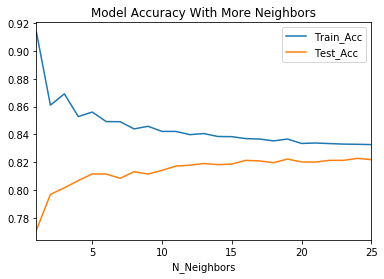

In [47]:
knn_results = pd.DataFrame({
    'N_Neighbors' : list(neighbor_count),
    'Train_Acc' : train_acc,
    'Test_Acc' : test_acc
})

knn_results.plot(x='N_Neighbors', title='Model Accuracy With More Neighbors')

In [55]:
param_grid = {
    'n_neighbors' : neighbor_count
}

knn = KNeighborsClassifier(n_jobs=-1)
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
print(f"Tuned Logistic Regression Parameters: {knn_cv.best_params_}.")
print(f"Best score is {knn_cv.best_score_}.")

Tuned Logistic Regression Parameters: {'n_neighbors': 21}.
Best score is 0.8177430677430677.


# Logistic Regression

In [61]:
c_range = np.logspace(-5, 8, 15)
train_acc = []
test_acc = []

for c in tqdm(c_range):
    lr = LogisticRegression(C = c, n_jobs=-1, solver='lbfgs')
    lr.fit(X_train, y_train)
    train_acc.append(lr.score(X_train, y_train))
    test_acc.append(lr.score(X_test, y_test))

100%|██████████| 15/15 [00:09<00:00,  1.57it/s]


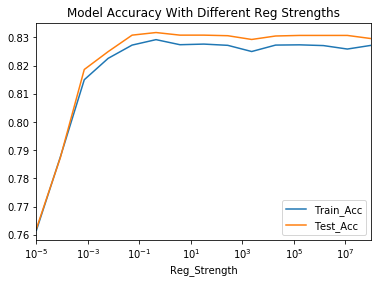

In [63]:
lr_results = pd.DataFrame({
    'Reg_Strength' : list(c_range),
    'Train_Acc' : train_acc,
    'Test_Acc' : test_acc
})

lr_results.plot(x='Reg_Strength', logx=True, title='Model Accuracy With Different Reg Strengths')

In [66]:
param_grid = {
    'C' : c_range
}

lr = LogisticRegression(n_jobs=-1, solver='lbfgs')
lr_cv = GridSearchCV(lr, param_grid, cv=5)
lr_cv.fit(X_train, y_train)
print(f"Tuned Logistic Regression Parameters: {lr_cv.best_params_}.")
print(f"Best score is {lr_cv.best_score_}.")

Tuned Logistic Regression Parameters: {'C': 31.622776601683793}.
Best score is 0.8277904527904528.


Things to do:

XGBoost

Keras